# <center>Прогнозирование индекса **S&P100** на своих предыдущих значениях и курсов входящих в него акций. 
# <center>Сравнение архитектур сетей на базе **LSTM** и **Transformers**

In [ ]:
# import os
# os.chdir("..")

# %load_ext autoreload
# %autoreload 2

# from dotenv import load_dotenv
# load_dotenv()

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir('drive/My Drive/Colab Notebooks/neural_OTUS/project1_sp100')

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
from tqdm import tqdm

# mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [4]:
import torch
from torch.utils.data import DataLoader, Dataset
from torch import nn
import torch.nn.functional as F

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

#### Данные
загрузим ранее подготовленный датасет

In [6]:
path_to_data = "data"

In [7]:
features = pd.read_csv(os.path.join(path_to_data, "sp100_15min.csv"), index_col=0)

In [8]:
features.head()

,AAPL,ABBV,ABT,ACN,ADBE,AIG,ALL,AMGN,AMT,AMZN,AXP,BA,BAC,BIIB,BK,BKNG,BLK,BMY,BRK-B,C,CAT,CHTR,CL,CMCSA,COF,COP,COST,CRM,CSCO,CVS,CVX,DD,DHR,DIS,DOW,DUK,EMR,EXC,F,FB,...,MCD,MDLZ,MDT,MET,MMM,MO,MRK,MS,MSFT,NEE,NFLX,NKE,NVDA,ORCL,OXY,PEP,PFE,PG,PM,PYPL,QCOM,RTX,SBUX,SLB,SO,SPG,T,TGT,TMO,TXN,UNH,UNP,UPS,USB,V,VZ,WBA,WFC,WMT,XOM
2018-10-15 04:15:00,53.728530,82.335268,67.871121,153.710081,245.01,46.671585,89.674787,186.465966,136.580973,1776.49,100.226066,346.176427,27.039223,329.86,46.895564,1803.945,405.821674,53.783799,206.0,65.284892,133.971554,309.57,59.521042,32.899359,88.92402,70.522537,222.79463,145.5,42.609957,70.004656,107.806388,63.283475,101.858176,109.147285,48.695704,73.434966,67.671718,40.711677,7.838263,152.85,...,156.647349,39.462066,90.860735,40.420197,184.867084,52.060669,65.418162,40.970776,105.607356,161.469784,337.20,73.986684,245.149201,46.20111,66.072322,99.908914,40.164271,75.933308,73.203519,77.63,60.112929,52.135536,54.706599,54.705365,40.486148,155.356286,29.003395,81.702085,228.798759,94.41119,254.662905,145.711303,108.035108,47.173193,136.250155,49.771425,69.860241,49.019968,90.07355,72.569641
2018-10-15 04:30:00,53.550596,82.335268,67.871121,153.710081,245.01,46.671585,89.674787,186.465966,136.580973,1772.50,100.226066,346.176427,26.943947,329.86,46.895564,1803.945,405.821674,53.783799,206.0,65.284892,133.971554,309.57,59.521042,32.899359,88.92402,70.522537,222.79463,145.5,42.609957,70.004656,107.806388,63.283475,101.858176,109.147285,48.695704,73.434966,67.671718,40.711677,7.838263,152.50,...,156.647349,39.462066,90.860735,40.420197,184.867084,52.060669,65.418162,40.970776,105.607356,161.469784,335.00,73.986684,245.149201,46.20111,66.072322,99.908914,40.164271,75.933308,73.203519,77.63,60.112929,52.135536,54.706599,54.705365,40.486148,155.356286,29.003395,81.702085,228.798759,94.41119,254.662905,145.711303,108.035108,47.173193,136.250155,49.771425,69.860241,49.019968,90.07355,72.569641
2018-10-15 04:45:00,53.587158,82.335268,67.871121,153.710081,245.01,46.671585,89.674787,186.465966,136.580973,1772.00,100.226066,346.176427,26.943947,329.86,46.895564,1803.945,405.821674,53.783799,206.0,65.284892,133.971554,309.57,59.521042,32.899359,88.92402,70.522537,222.79463,145.5,42.609957,70.004656,107.806388,63.283475,101.858176,109.147285,48.695704,73.434966,67.671718,40.711677,7.838263,152.05,...,156.647349,39.462066,90.860735,40.420197,184.867084,52.060669,65.418162,40.970776,105.665757,161.469784,335.00,73.927926,245.149201,46.20111,66.072322,99.908914,40.164271,75.933308,73.203519,77.63,60.112929,52.135536,54.706599,54.705365,40.486148,155.356286,29.003395,81.702085,228.798759,94.41119,254.662905,145.711303,108.035108,47.173193,136.250155,49.771425,69.860241,49.019968,90.07355,72.569641
2018-10-15 05:00:00,53.453099,82.335268,67.871121,153.710081,245.01,46.671585,89.674787,186.465966,136.580973,1772.00,100.226066,346.176427,27.001113,329.86,46.895564,1803.945,405.821674,53.783799,206.0,65.284892,133.971554,309.57,59.521042,32.899359,88.92402,70.522537,222.79463,145.5,42.609957,70.004656,107.806388,63.283475,101.858176,109.147285,48.695704,73.434966,67.671718,40.711677,7.838263,152.06,...,156.647349,39.462066,90.860735,40.420197,184.867084,52.060669,65.418162,40.970776,105.315354,161.469784,335.00,74.025856,245.149201,46.20111,66.072322,99.908914,40.164271,75.933308,73.203519,77.63,60.112929,52.135536,54.706599,54.705365,40.486148,155.356286,29.003395,81.702085,228.798759,94.41119,254.662905,145.711303,108.035108,47.173193,136.250155,49.771425,69.860241,49.019968,90.07355,72.569641
2018-10-15 05:15:00,53.453099,82.335268,67.871121,153.710081,245.01,46.671585,89.674787,186.465966,136.580973,1773.37,100.226066,346.176427,27.001113,329.86,46.895564,1803.945,405.821674,53.783799,206.0,65.284892,133.971554,309.57,59.521042,32.899359,88.92402,70.522537,222.79463,145.5,42.609957,70.004656,107.687518,63.283475,101.858176,109.147285,48.695704,73.434966,67.671718,40.711677,7.838263,152.17,...,156.647349,39.462066,90

In [9]:
features.shape

(31551, 101)

Первые **25 000** строк выделим под **обучение**, остальное - под **валидацию**

In [10]:
TRAIN_SPLIT = 25_000

Посмотрим для наглядности на целевую переменную и некоторые курсы акций

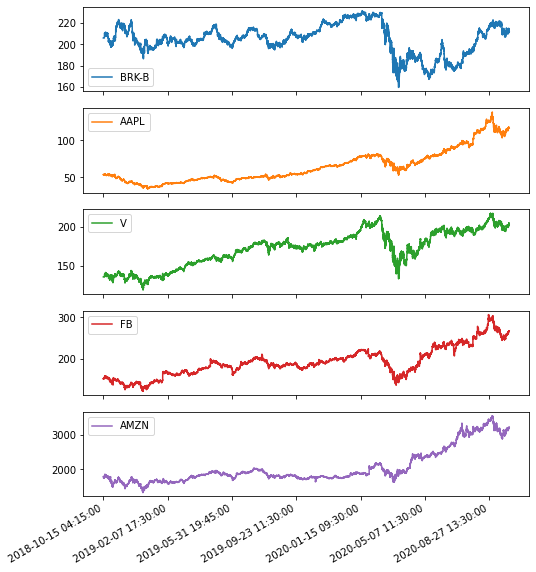

In [11]:
mpl.rcParams['figure.figsize'] = (8, 10)

tickers = ["BRK-B", "AAPL", "V", "FB", "AMZN"]
features[tickers].plot(subplots=True);

Стандартизируем (нормализуем) набор данных. Для расчета параметров стандартизации используем только **train**

In [12]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

In [13]:
dataset = (dataset - data_mean) / data_std

In [ ]:
# dataset

Будем делать два варианта прогноза - точечное прогнозирование (одно значение, например - на следующий день) и интервальный прогноз (например - 10 дней вперед, с учетом выходных это будет две недели).    

Вариант просто с классификацией ["buy", ""sell", "hold"] считаю **недостаточным**, так как, считаю, имеет значение величина роста или падения, а не просто направление

## Глобальные параметры

In [34]:
past_history = 90  # смотрим историю за 90 дней (рабочих)
STEP = 1           # данные берем без пропусков
BATCH_SIZE = 64
INPUT_SIZE = dataset.shape[1]
INPUT_SIZE

101

In [18]:
# номер таргетной фичи в датасете
TARGET_NUM = list(features.columns).index("BRK-B")
TARGET_NUM

18

##  Рабочие функции

In [19]:
class DatasetCustom(Dataset):
    """
    Кастомный класс датасета
    """
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, key):
        return self.x[key], self.y[key]

In [20]:
def train_model(model, dataloaders: dict, optimizer, num_epochs=3):
    since = time.time()

#     history = {'train': [], 'val': []}
    loss_history = {'train': [], 'val': []}

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
#         print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
#             running_corrects = 0

            # Iterate over data.
            n_batches = len(dataloaders[phase])
            for inputs, y in dataloaders[phase]:
                inputs = inputs.to(device).float()
                y = y.to(device).float()

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    outputs = model(inputs)
                    loss = model.loss(outputs, y)

#                     _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
#                 running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
#             epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f}'.format(phase, epoch_loss))
            loss_history[phase].append(epoch_loss)
#             history[phase].append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    return model, loss_history

def test_model(model, testloader):
    n_batches = len(testloader)
    running_loss = 0.0
#     running_corrects = 0

    for inputs, y in tqdm(testloader, total=n_batches):
        inputs = inputs.to(device)
        y = y.to(device)

        outputs = model(inputs)
        loss = model.loss(outputs, y)
#         _, preds = torch.max(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
#         running_corrects += torch.sum(preds == labels.data)

    loss = running_loss / len(testloader.dataset)
#     acc = running_corrects.double() / len(testloader.dataset)
    print('Val Loss: {:.4f}'.format(loss))
    return loss

In [21]:
def loss_history_plot(loss_history, title):
    loss = loss_history['train']
    val_loss = loss_history['val']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.xlabel("Epochs")
    plt.legend()

    plt.show()

In [23]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    """
    Функция организации временных интервалов
    """
    
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels).reshape((len(labels), -1))

## Построение модели

Архитектура класса модели позволяет строить сеть как с использованием ячеек **LSTM**, так и с использованием **Transformers**

In [41]:
class SP100LstmTransNet(nn.Module):
    
    def __init__(self, predict_num, input_size, 
                 criterion=None, seq_len=90, 
                 dropout=0.1, hidden_size =100,
                 lstm_or_trans: str="lstm",
                 lstm_num_layers=2, num_enc_dec_layers=6,
                 has_conv=True, second_cell=True, 
                 ):
        super().__init__()
        self.input_size = input_size
        self.seq_len = seq_len
        self.hidden_size = hidden_size  # должно делиться на цело на nhead=10
        self.predict_num = predict_num
        self.lstm_or_trans = lstm_or_trans
        self.criterion = criterion
        self.lstm_num_layers = lstm_num_layers
        self.num_enc_dec_layers = num_enc_dec_layers
        self.second_cell = second_cell
        self.has_conv = has_conv
        
        self.fc_input = nn.Linear(input_size, hidden_size)
        self.conv1 = nn.Conv1d(hidden_size, hidden_size, kernel_size=3, padding=1)
        self.bn_c1 = nn.BatchNorm1d(hidden_size)
        self.ln_c1 = nn.LayerNorm([hidden_size, seq_len])
        self.conv2 = nn.Conv1d(hidden_size, hidden_size, kernel_size=3, padding=1)
        self.bn_c2 = nn.BatchNorm1d(hidden_size)
        self.ln_c2 = nn.LayerNorm([hidden_size, seq_len])
        self.lstm1 = nn.LSTM(hidden_size, hidden_size, lstm_num_layers, 
                             dropout=dropout)
        self.trans1 = nn.Transformer(d_model=hidden_size, nhead=10, dropout=dropout, 
                                     num_encoder_layers=num_enc_dec_layers, 
                                     num_decoder_layers=num_enc_dec_layers)
        self.ln_lstm1 = nn.LayerNorm([seq_len, hidden_size])
        # self.bn_lstm1 = nn.BatchNorm1d(seq_len)
        self.lstm2 = nn.LSTM(hidden_size, hidden_size, lstm_num_layers, 
                                 dropout=dropout)
        self.trans2 = nn.Transformer(d_model=hidden_size, nhead=10, dropout=dropout, 
                                     num_encoder_layers=num_enc_dec_layers, 
                                     num_decoder_layers=num_enc_dec_layers)
        self.ln_lstm2 = nn.LayerNorm([seq_len, hidden_size])
        # self.bn_lstm2 = nn.BatchNorm1d(seq_len)

        self.fc1 = nn.Linear(seq_len * hidden_size, hidden_size)
        self.ln_fc1 = nn.LayerNorm(hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.bn_fc2 = nn.BatchNorm1d(hidden_size)
        self.fc3 = nn.Linear(hidden_size, predict_num)

    def forward(self, x):
        chunk_len = x.shape[0]  # длинна батча или группы данных на входе
        x = x.float()

        x = self.fc_input(x.reshape(-1, self.input_size)).reshape(-1, self.seq_len, self.hidden_size)
        # conv block
        if self.has_conv:
            x = F.relu(self.conv1(x.transpose(1, 2)))  # (cl, hs, sl)
            # x = self.bn_c1(x)
            x = self.ln_c1(x)
            x = F.relu(self.conv2(x))  # (cl, hs, sl)
            # x = self.bn_c2(x)
            x = self.ln_c2(x)
            x = x.transpose(1, 2)  # (cl, sl, hs)

        # lstm/transformers block
        if self.lstm_or_trans == "lstm":
            x = self.lstm1(x.transpose(1, 0))[0].transpose(1, 0)  #  change to "batch first", (cl, sl, hs)
        elif self.lstm_or_trans == "trans":
            tgt = torch.zeros((self.seq_len, chunk_len, self.hidden_size)).to(device)
            x = self.trans1(x.transpose(1, 0), tgt).transpose(1, 0)  #  (cl, sl, hs)
        else:
            raise ValueError(f"Parameter 'lstm_or_trans' must be one of 'lstm' or 'trans' but got '{self.lstm_or_trans}'")

        x = self.ln_lstm1(x)  # (cl, sl, hs)
        # x = self.bn_lstm1(x)  # (cl, sl, hs)

        if self.second_cell:
            if self.lstm_or_trans == "lstm":
                x = self.lstm2(x.transpose(1, 0))[0].transpose(1, 0)  #  change to "batch first", (cl, sl, hs)
            elif self.lstm_or_trans == "trans":
                tgt = torch.zeros((self.seq_len, chunk_len, self.hidden_size)).to(device)
                x = self.trans2(x.transpose(1, 0), tgt).transpose(1, 0)  #  (cl, sl, hs)
            else:
                raise ValueError(f"Parameter 'lstm_or_trans' must be one of 'lstm' or 'trans' but got '{self.lstm_or_trans}'")

            x = self.ln_lstm2(x)  # (cl, sl, hs)
            # x = self.bn_lstm2(x)  # (cl, sl, hs)
        
        # full connect output block
        x = x.reshape(chunk_len, self.seq_len * self.hidden_size)
        x = F.relu(self.fc1(x))
        x = self.ln_fc1(x)
        x = F.relu(self.fc2(x))
        x = self.bn_fc2(x)
        x = self.fc3(x)
        return x
    
    def loss(self, outputs, targets):
        return self.criterion(outputs, targets).mean()

### Проверим модель на корректность

In [36]:
x_test = torch.randn([32, 90, INPUT_SIZE])
target_num_test = 10
x_test.shape, target_num_test

(torch.Size([32, 90, 101]), 10)

#### LSTM - mode

In [37]:
model = SP100LstmTransNet(target_num_test, input_size=INPUT_SIZE, lstm_or_trans="lstm").to(device)
assert model(x_test.to(device)).shape == (x_test.shape[0], target_num_test)

model = SP100LstmTransNet(target_num_test, input_size=INPUT_SIZE, lstm_or_trans="lstm", 
                          has_conv=False, second_cell=False).to(device)
assert model(x_test.to(device)).shape == (x_test.shape[0], target_num_test)

model(x_test.to(device)).shape

torch.Size([32, 10])

#### Transformers - mode

In [38]:
model = SP100LstmTransNet(target_num_test, input_size=INPUT_SIZE, lstm_or_trans="trans").to(device)
assert model(x_test.to(device)).shape == (x_test.shape[0], target_num_test)

model = SP100LstmTransNet(target_num_test, input_size=INPUT_SIZE, lstm_or_trans="trans", 
                          has_conv=False, second_cell=False).to(device)
assert model(x_test.to(device)).shape == (x_test.shape[0], target_num_test)

model(x_test.to(device)).shape

torch.Size([32, 10])

## <center>Точечное прогнозирование

In [42]:
predict_num, future_target = 1, 10  # предсказываем только 1 значение на 10 отсчетов вперед
single_step = True

### Сформирум размеченный временной ряд

In [29]:
x_train_single, y_train_single = multivariate_data(dataset, dataset[:, TARGET_NUM], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=single_step)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, TARGET_NUM],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=single_step)
x_train_single.shape, y_train_single.shape

((24910, 90, 101), (24910, 1))

### Создадим загрузчик данных по батчам

In [30]:
train_single_dataset = DatasetCustom(x_train_single, y_train_single)
val_single_dataset = DatasetCustom(x_val_single, y_val_single)

In [31]:
dataloader_train = DataLoader(train_single_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              drop_last=False
                              )

dataloader_val = DataLoader(val_single_dataset,
                            batch_size=BATCH_SIZE,
                            shuffle=True,
                            drop_last=False
                            )
len(dataloader_train), len(dataloader_val)

(390, 101)

Инициализируем архив точечных моделей

In [32]:
single_models = {}

### Готовим и тренируем модель: LSTM

#### 1) lstm, conv 

In [44]:
%%time

dataloaders = {
    "train": dataloader_train, 
    "val": dataloader_val
}

model = SP100LstmTransNet(
    predict_num=predict_num, input_size=INPUT_SIZE, criterion=nn.MSELoss(), 
    dropout=0.5, hidden_size=100, 
    lstm_or_trans="lstm", lstm_num_layers=2, 
    has_conv=True, second_cell=False,
).to(device)
optimizer = torch.optim.Adadelta(model.parameters())

model, loss_history = train_model(
    model=model, dataloaders=dataloaders, 
    optimizer=optimizer, num_epochs=10)

single_models["LSTM Conv"] = model

Epoch 1/10
train Loss: 0.1405
val Loss: 1.3259

Epoch 2/10
train Loss: 0.0763
val Loss: 0.7836

Epoch 3/10
train Loss: 0.0581
val Loss: 2.4397

Epoch 4/10
train Loss: 0.0494
val Loss: 1.4724

Epoch 5/10
train Loss: 0.0480
val Loss: 1.8771

Epoch 6/10
train Loss: 0.0457
val Loss: 1.9003

Epoch 7/10
train Loss: 0.0396
val Loss: 2.0400

Epoch 8/10
train Loss: 0.0390
val Loss: 2.4668

Epoch 9/10
train Loss: 0.0395
val Loss: 4.9028

Epoch 10/10
train Loss: 0.0353
val Loss: 2.9229

Training complete in 1m 16s
CPU times: user 1min 13s, sys: 3.38 s, total: 1min 16s
Wall time: 1min 16s


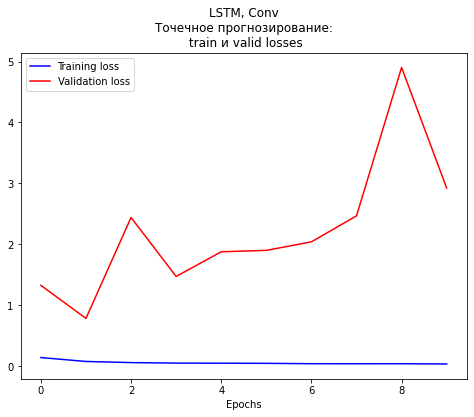

In [45]:
mpl.rcParams['figure.figsize'] = (8, 6)

loss_history_plot(loss_history,
                   'LSTM, Conv\nТочечное прогнозирование:\n train и valid losses')

#### 2) lstm, not conv 

In [47]:
%%time

dataloaders = {
    "train": dataloader_train, 
    "val": dataloader_val
}

model = SP100LstmTransNet(
    predict_num=predict_num, input_size=INPUT_SIZE, criterion=nn.MSELoss(), 
    dropout=0.3, hidden_size=100, 
    lstm_or_trans="lstm", lstm_num_layers=2, 
    has_conv=False, second_cell=False,
).to(device)
optimizer = torch.optim.Adadelta(model.parameters())

model, loss_history = train_model(
    model=model, dataloaders=dataloaders, 
    optimizer=optimizer, num_epochs=10)

single_models["LSTM NotConv"] = model

Epoch 1/10
train Loss: 0.1144
val Loss: 0.6086

Epoch 2/10
train Loss: 0.0614
val Loss: 0.3982

Epoch 3/10
train Loss: 0.0500
val Loss: 1.7060

Epoch 4/10
train Loss: 0.0454
val Loss: 0.5541

Epoch 5/10
train Loss: 0.0428
val Loss: 0.1680

Epoch 6/10
train Loss: 0.0377
val Loss: 0.3600

Epoch 7/10
train Loss: 0.0362
val Loss: 0.8992

Epoch 8/10
train Loss: 0.0340
val Loss: 0.2242

Epoch 9/10
train Loss: 0.0335
val Loss: 0.4681

Epoch 10/10
train Loss: 0.0327
val Loss: 0.3974

Training complete in 1m 2s
CPU times: user 1min 1s, sys: 587 ms, total: 1min 2s
Wall time: 1min 2s


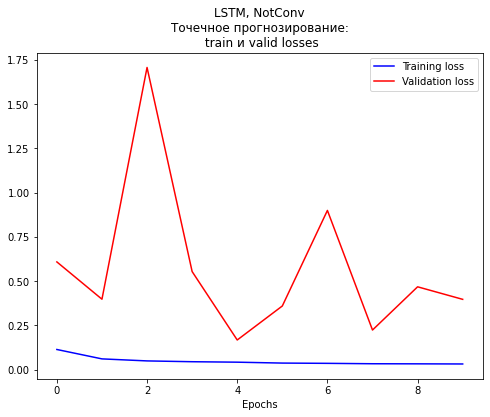

In [48]:
mpl.rcParams['figure.figsize'] = (8, 6)

loss_history_plot(loss_history,
                   'LSTM, NotConv\nТочечное прогнозирование:\n train и valid losses')

### Тест-прогнозы

In [ ]:
# for x, y in list(dataloader_val)[:10]:
#     print(x[:1].to(device).shape)

In [87]:
def history_predict_plot(history, true_future, predictions: dict=None, title='', 
                         future_target: int=10, predict_num: int=1, target_num=TARGET_NUM):
  def create_time_steps(length):
    return list(range(-length, 0))
    
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = future_target

  plt.plot(num_in, np.array(history[:, target_num]), label='History', marker=".")
  plt.plot(np.arange(future_target - predict_num + 1, future_target + 1).flatten() / STEP, 
           np.array(true_future).flatten(), 'go-',
           label='True Future')
  if predictions is not None:
      for marker, prediction in zip(['rx-', 'mx-','yx-','cx-','bx-',], predictions):
        plt.plot(np.arange(future_target - predict_num + 1, future_target + 1).flatten() / STEP, 
                 np.array(predictions[prediction]).flatten(), marker,
                 label=prediction)
  plt.legend(loc='upper left')
  plt.title(title)
  plt.show()

In [82]:
# for x, y in list(dataloader_val)[:10]:
#   history_predict_plot(x[0], y[0], 
#                        {key: model(x[:1].to(device)).detach().cpu().numpy() 
#                                         for key, model in single_models.items()},  
#                        "Точечное прогнозирование")

### Готовим и тренируем модель: Transformers

#### 3) trans, conv 

In [61]:
%%time

dataloaders = {
    "train": dataloader_train, 
    "val": dataloader_val
}

model = SP100LstmTransNet(
    predict_num=predict_num, input_size=INPUT_SIZE, criterion=nn.MSELoss(), 
    dropout=0.3, hidden_size=100, 
    lstm_or_trans="trans", num_enc_dec_layers=6, 
    has_conv=True, second_cell=False,
).to(device)
optimizer = torch.optim.Adadelta(model.parameters())

model, loss_history = train_model(
    model=model, dataloaders=dataloaders, 
    optimizer=optimizer, num_epochs=10)

single_models["Trans Conv"] = model

Epoch 1/10
train Loss: 0.3077
val Loss: 5.7860

Epoch 2/10
train Loss: 0.1122
val Loss: 1.6154

Epoch 3/10
train Loss: 0.0937
val Loss: 5.6641

Epoch 4/10
train Loss: 0.0759
val Loss: 3.7602

Epoch 5/10
train Loss: 0.0781
val Loss: 2.9651

Epoch 6/10
train Loss: 0.0635
val Loss: 2.1244

Epoch 7/10
train Loss: 0.0670
val Loss: 5.2769

Epoch 8/10
train Loss: 0.0606
val Loss: 3.4603

Epoch 9/10
train Loss: 0.0577
val Loss: 3.5726

Epoch 10/10
train Loss: 0.0503
val Loss: 4.7399

Training complete in 9m 22s
CPU times: user 7min 1s, sys: 2min 18s, total: 9min 20s
Wall time: 9min 21s


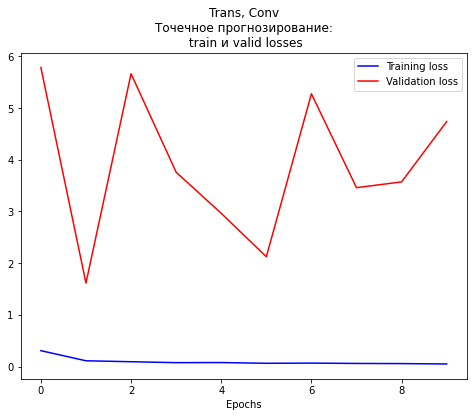

In [62]:
mpl.rcParams['figure.figsize'] = (8, 6)

loss_history_plot(loss_history,
                   'Trans, Conv\nТочечное прогнозирование:\n train и valid losses')

#### 2) trans, not conv 

In [64]:
%%time

dataloaders = {
    "train": dataloader_train, 
    "val": dataloader_val
}

model = SP100LstmTransNet(
    predict_num=predict_num, input_size=INPUT_SIZE, criterion=nn.MSELoss(), 
    dropout=0.3, hidden_size=100, 
    lstm_or_trans="trans", num_enc_dec_layers=6, 
    has_conv=False, second_cell=False,
).to(device)
optimizer = torch.optim.Adadelta(model.parameters())

model, loss_history = train_model(
    model=model, dataloaders=dataloaders, 
    optimizer=optimizer, num_epochs=10)

single_models["Trans NotConv"] = model

Epoch 1/10
train Loss: 0.2459
val Loss: 0.7649

Epoch 2/10
train Loss: 0.0938
val Loss: 1.2891

Epoch 3/10
train Loss: 0.0781
val Loss: 3.0129

Epoch 4/10
train Loss: 0.0678
val Loss: 1.2532

Epoch 5/10
train Loss: 0.0621
val Loss: 0.8173

Epoch 6/10
train Loss: 0.0632
val Loss: 0.3484

Epoch 7/10
train Loss: 0.0561
val Loss: 0.4797

Epoch 8/10
train Loss: 0.0565
val Loss: 0.4966

Epoch 9/10
train Loss: 0.0510
val Loss: 0.6178

Epoch 10/10
train Loss: 0.0489
val Loss: 1.2973

Training complete in 8m 58s
CPU times: user 6min 39s, sys: 2min 17s, total: 8min 56s
Wall time: 8min 58s


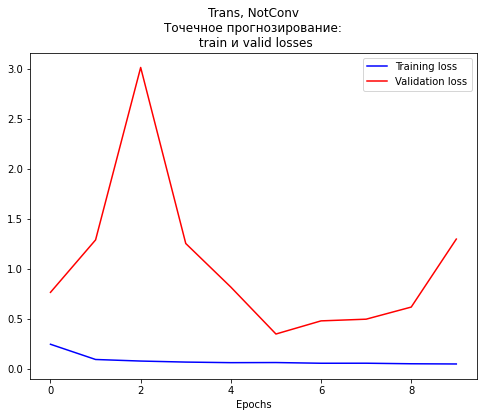

In [66]:
mpl.rcParams['figure.figsize'] = (8, 6)

loss_history_plot(loss_history,
                   'Trans, NotConv\nТочечное прогнозирование:\n train и valid losses')

### Тест-прогнозы

In [ ]:
# for x, y in list(dataloader_val)[:10]:
#     print(x[:1].to(device).shape)

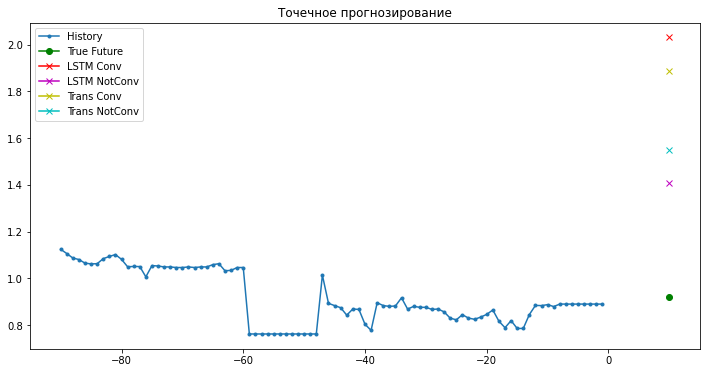

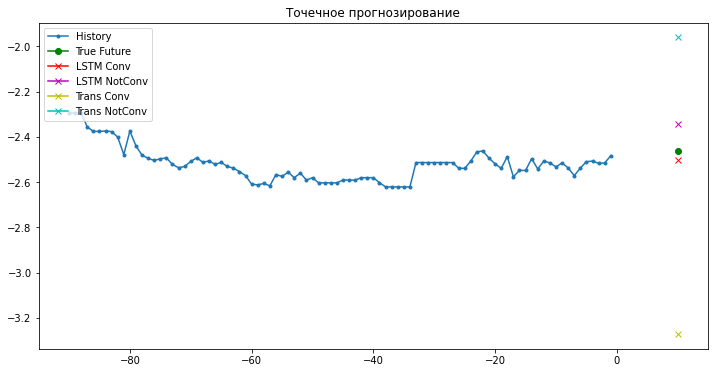

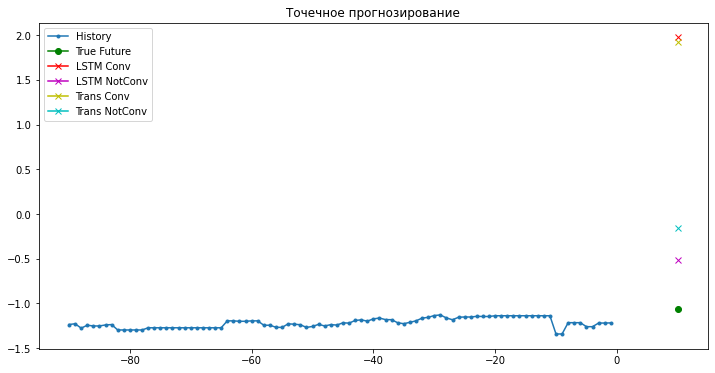

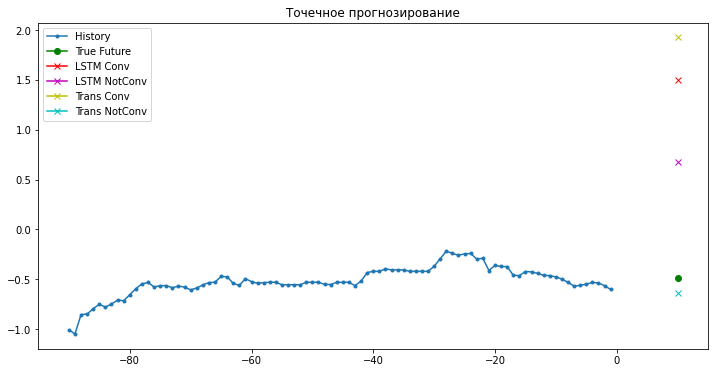

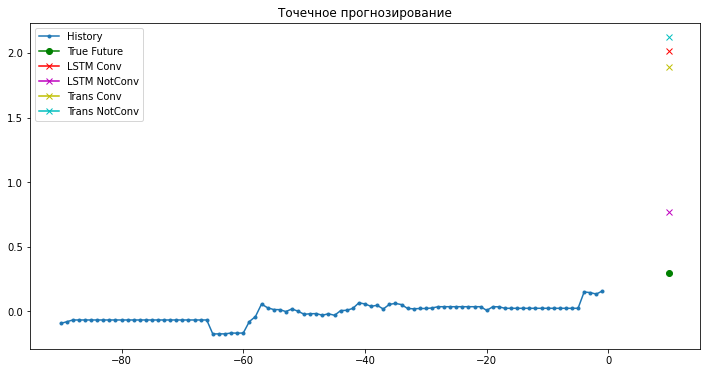

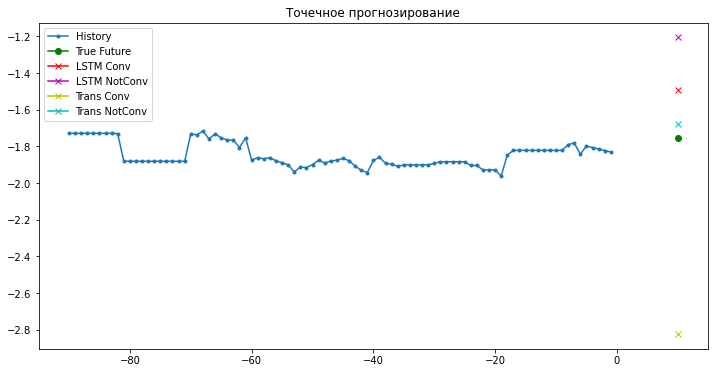

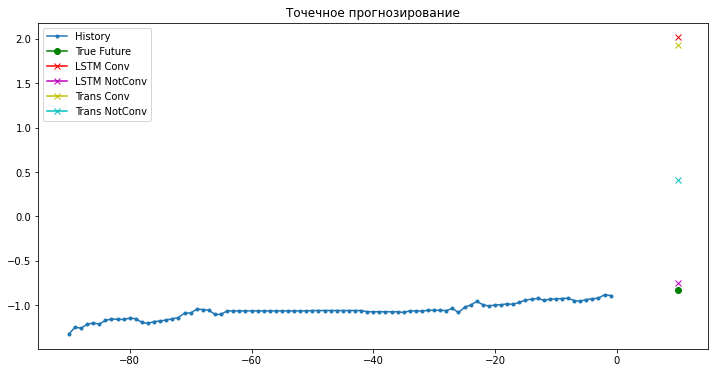

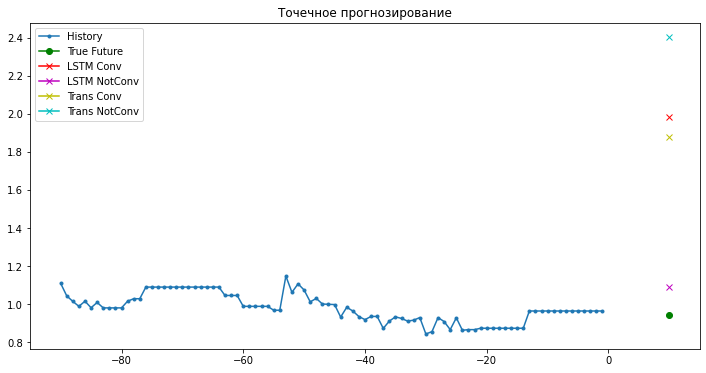

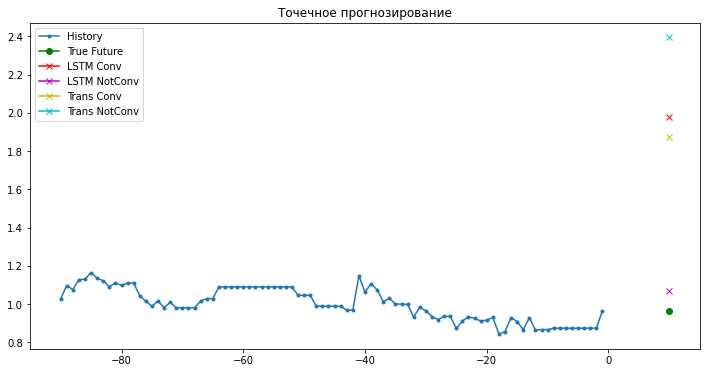

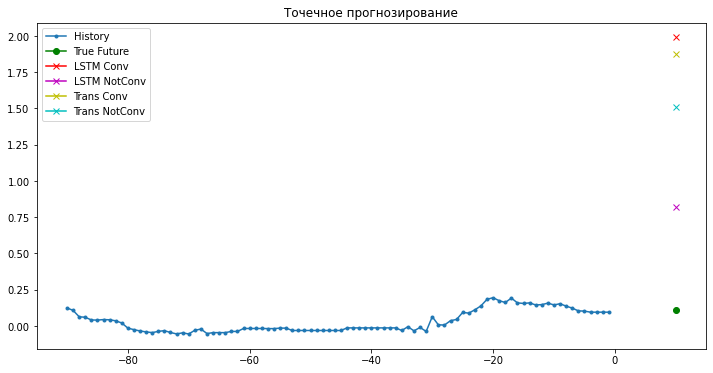

In [81]:
for x, y in list(dataloader_val)[:10]:
  history_predict_plot(x[0], y[0], 
                       {key: model(x[:1].to(device)).detach().cpu().numpy() 
                                        for key, model in single_models.items()}, 
                       "Точечное прогнозирование", 
                       future_target=future_target, predict_num=predict_num)

## <center>Интервальное прогнозирование
Прогнозирование **интервала** будущих значений

Будем прогнозировать на 10 дней вперед

In [69]:
predict_num, future_target_multi = 10, 10  # предсказываем только 1 значение на 10 отсчетов вперед
single_step = False

### Сформирум размеченный временной ряд

In [70]:
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, TARGET_NUM], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target_multi, STEP, 
                                                 single_step=single_step)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, TARGET_NUM],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target_multi, STEP, 
                                             single_step=single_step)
x_train_multi.shape, y_train_multi.shape

((24910, 90, 101), (24910, 10))

### Создадим загрузчик данных по батчам

In [71]:
train_multi_dataset = DatasetCustom(x_train_multi, y_train_multi)
val_multi_dataset = DatasetCustom(x_val_multi, y_val_multi)

In [72]:
train_multi_dataloader = DataLoader(train_multi_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              drop_last=True
                              )

val_multi_dataloader = DataLoader(val_multi_dataset,
                            batch_size=BATCH_SIZE,
                            shuffle=True,
                            drop_last=True
                            )

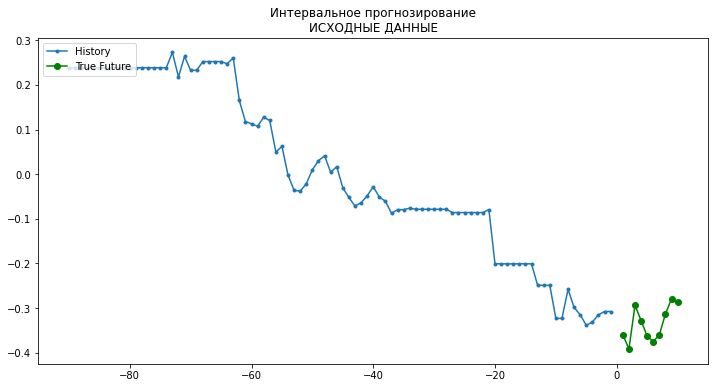

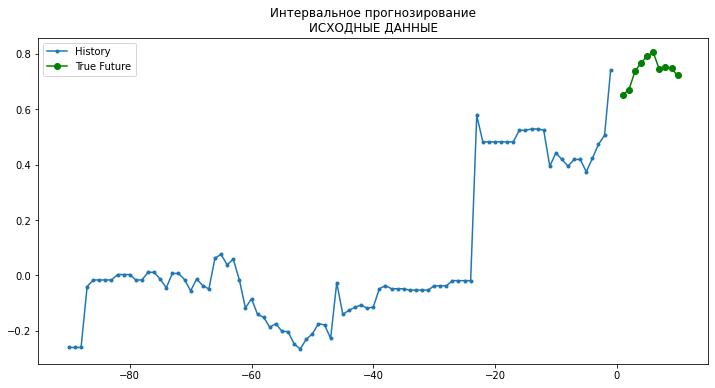

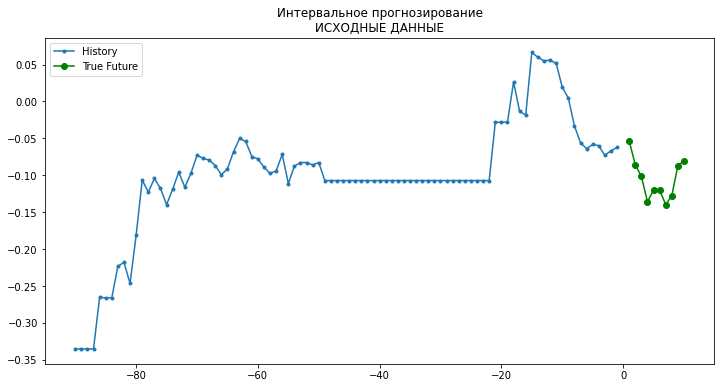

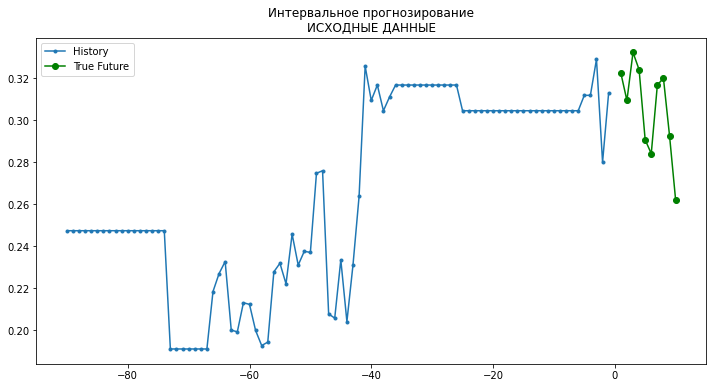

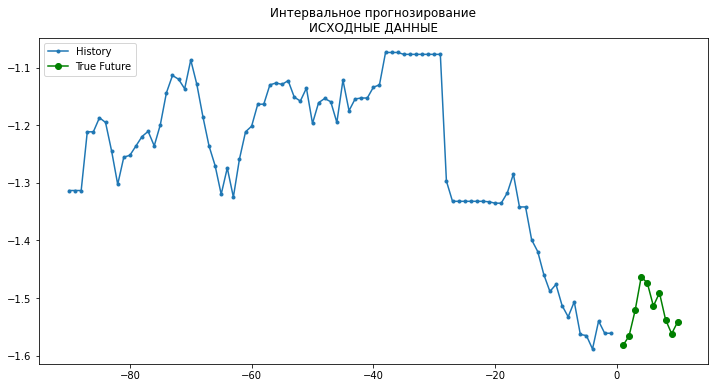

In [83]:
for x, y in list(train_multi_dataloader)[:5]:
    # print(y[0])
    history_predict_plot(x[0], y[0], None, "Интервальное прогнозирование\nИСХОДНЫЕ ДАННЫЕ", 
                         future_target=future_target_multi, predict_num=predict_num)

Инициализируем архив интервальных (**multi**) моделей

In [84]:
multi_models = {}

### Готовим и тренируем модель: LSTM

#### 1) lstm, conv 

In [85]:
%%time

dataloaders = {
    "train": train_multi_dataloader, 
    "val": val_multi_dataloader
}

model = SP100LstmTransNet(
    predict_num=predict_num, input_size=INPUT_SIZE, criterion=nn.MSELoss(), 
    dropout=0.3, hidden_size=100, 
    lstm_or_trans="lstm", lstm_num_layers=2, 
    has_conv=True, second_cell=True,  # added second_cell
).to(device)
optimizer = torch.optim.Adadelta(model.parameters())

model, loss_history = train_model(
    model=model, dataloaders=dataloaders, 
    optimizer=optimizer, num_epochs=10)

multi_models["LSTM Conv"] = model

Epoch 1/10
train Loss: 0.1185
val Loss: 201.4093

Epoch 2/10
train Loss: 0.0640
val Loss: 2.4147

Epoch 3/10
train Loss: 0.0490
val Loss: 1.7258

Epoch 4/10
train Loss: 0.0478
val Loss: 1.3922

Epoch 5/10
train Loss: 0.0407
val Loss: 1.9926

Epoch 6/10
train Loss: 0.0404
val Loss: 0.7404

Epoch 7/10
train Loss: 0.0392
val Loss: 0.3964

Epoch 8/10
train Loss: 0.0349
val Loss: 0.4601

Epoch 9/10
train Loss: 0.0359
val Loss: 0.5297

Epoch 10/10
train Loss: 0.0331
val Loss: 1.4849

Training complete in 2m 2s
CPU times: user 1min 58s, sys: 3.2 s, total: 2min 1s
Wall time: 2min 1s


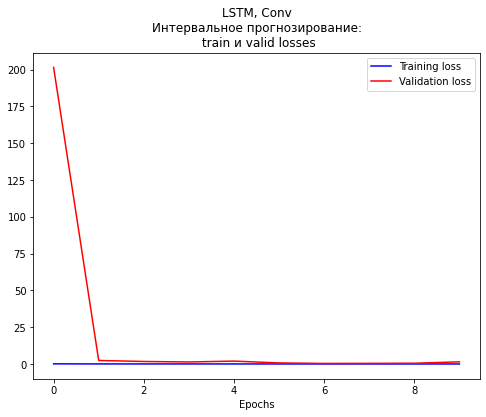

In [90]:
mpl.rcParams['figure.figsize'] = (8, 6)

loss_history_plot(loss_history,
                   'LSTM, Conv\nИнтервальное прогнозирование:\n train и valid losses')

#### 2) lstm, not conv 

In [91]:
%%time

dataloaders = {
    "train": train_multi_dataloader, 
    "val": val_multi_dataloader
}

model = SP100LstmTransNet(
    predict_num=predict_num, input_size=INPUT_SIZE, criterion=nn.MSELoss(), 
    dropout=0.3, hidden_size=100, 
    lstm_or_trans="lstm", lstm_num_layers=2, 
    has_conv=False, second_cell=True,  # added second_cell
).to(device)
optimizer = torch.optim.Adadelta(model.parameters())

model, loss_history = train_model(
    model=model, dataloaders=dataloaders, 
    optimizer=optimizer, num_epochs=10)

multi_models["LSTM NotConv"] = model

Epoch 1/10
train Loss: 0.1008
val Loss: 0.1692

Epoch 2/10
train Loss: 0.0515
val Loss: 0.2343

Epoch 3/10
train Loss: 0.0466
val Loss: 0.3133

Epoch 4/10
train Loss: 0.0437
val Loss: 0.3325

Epoch 5/10
train Loss: 0.0438
val Loss: 0.2487

Epoch 6/10
train Loss: 0.0430
val Loss: 0.2681

Epoch 7/10
train Loss: 0.0396
val Loss: 0.1820

Epoch 8/10
train Loss: 0.0354
val Loss: 0.3508

Epoch 9/10
train Loss: 0.0371
val Loss: 0.3115

Epoch 10/10
train Loss: 0.0367
val Loss: 0.3877

Training complete in 1m 43s
CPU times: user 1min 41s, sys: 2.08 s, total: 1min 43s
Wall time: 1min 43s


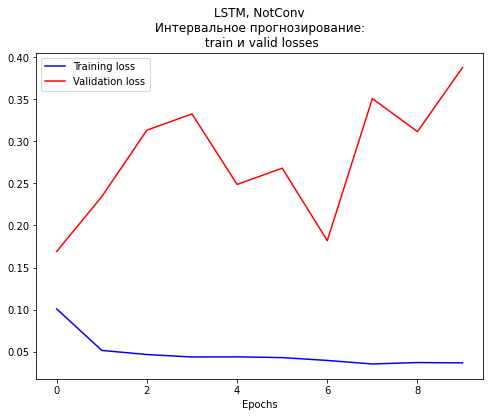

In [92]:
mpl.rcParams['figure.figsize'] = (8, 6)

loss_history_plot(loss_history,
                   'LSTM, NotConv\nИнтервальное прогнозирование:\n train и valid losses')

### Тест-прогнозы

In [ ]:
# for x, y in list(val_multi_dataloader)[:10]:
#     print(x[:1].to(device).shape)

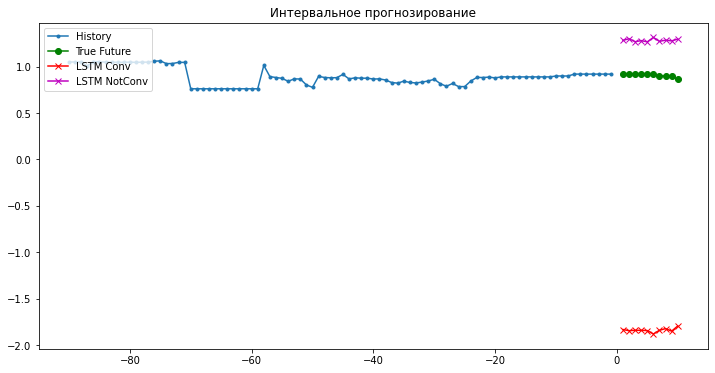

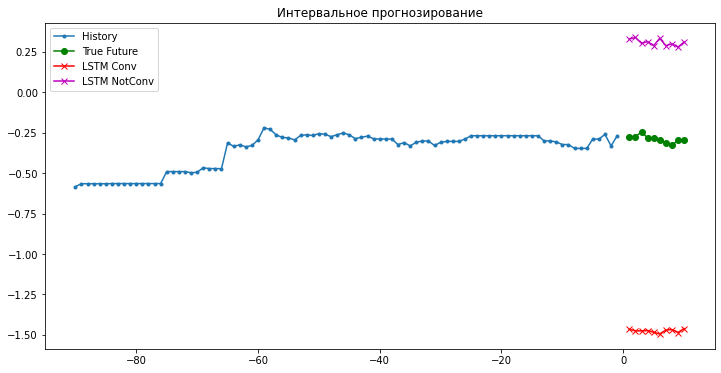

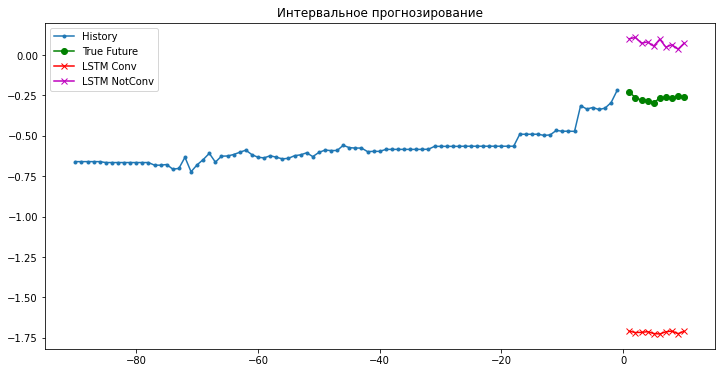

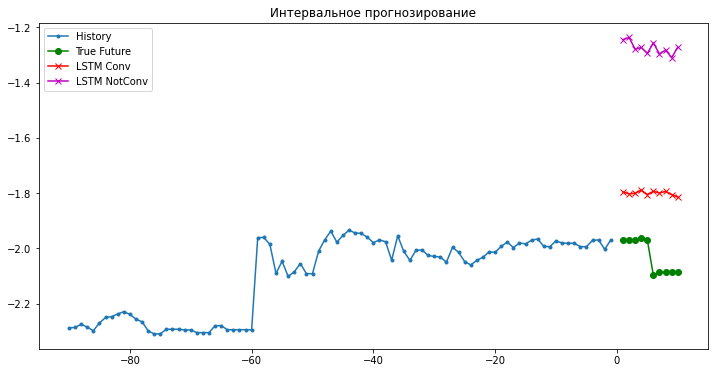

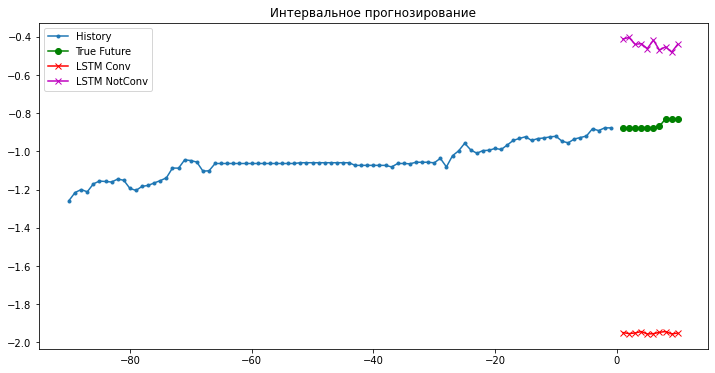

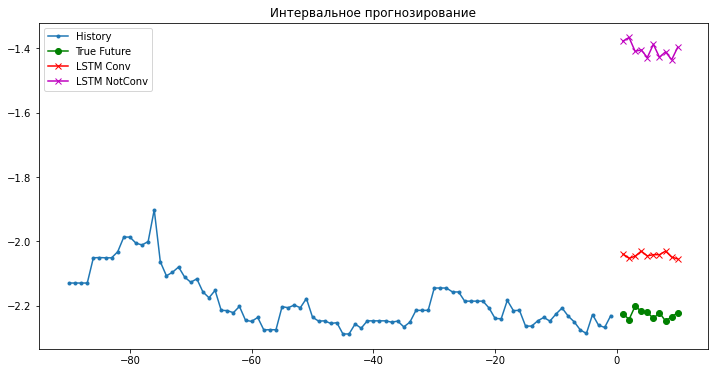

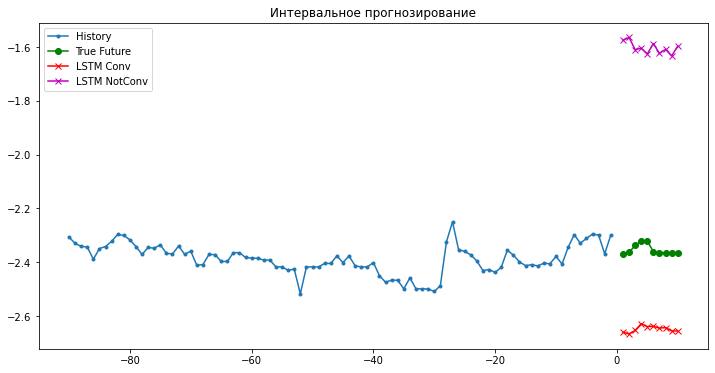

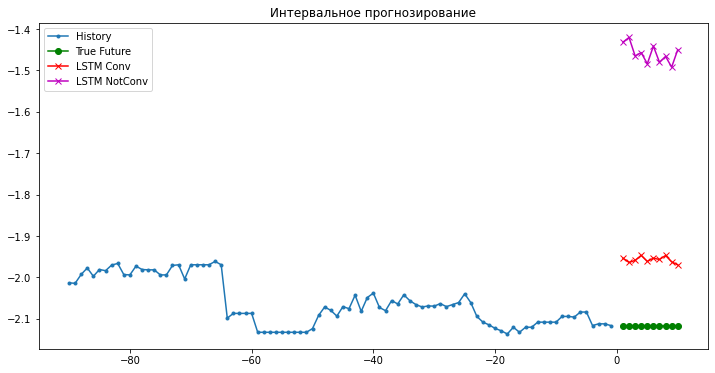

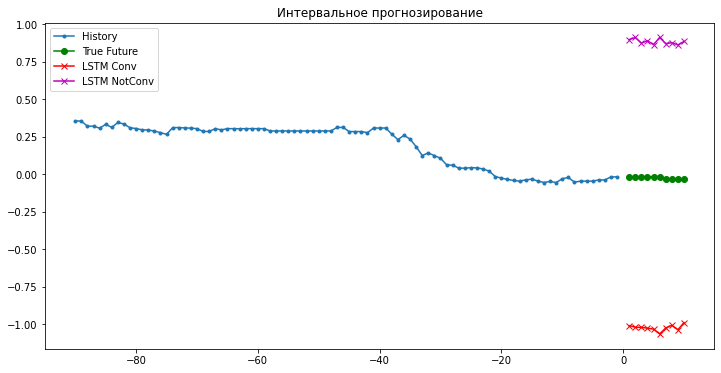

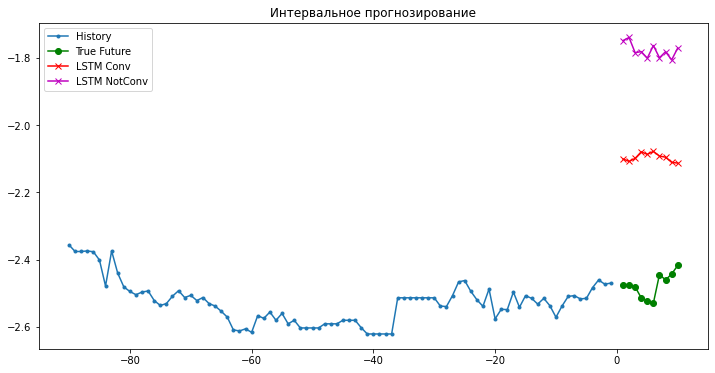

In [93]:
for x, y in list(val_multi_dataloader)[:10]:
  history_predict_plot(x[0], y[0], 
                       {key: model(x[:1].to(device)).detach().cpu().numpy() 
                                        for key, model in multi_models.items()},  
                       "Интервальное прогнозирование", 
                       future_target=future_target_multi, predict_num=predict_num)

### Готовим и тренируем модель: Transformers

#### 3) trans, conv 

In [94]:
%%time

dataloaders = {
    "train": train_multi_dataloader, 
    "val": val_multi_dataloader
}

model = SP100LstmTransNet(
    predict_num=predict_num, input_size=INPUT_SIZE, criterion=nn.MSELoss(),  
    dropout=0.3, hidden_size=100, 
    lstm_or_trans="trans", num_enc_dec_layers=6, 
    has_conv=True, second_cell=True,  # added second_cell
).to(device)
optimizer = torch.optim.Adadelta(model.parameters())

model, loss_history = train_model(
    model=model, dataloaders=dataloaders, 
    optimizer=optimizer, num_epochs=10)

multi_models["Trans Conv"] = model

Epoch 1/10
train Loss: 0.9111
val Loss: 2.4567

Epoch 2/10
train Loss: 1.0102
val Loss: 2.3231

Epoch 3/10
train Loss: 1.0088
val Loss: 2.4039

Epoch 4/10
train Loss: 1.0087
val Loss: 2.4418

Epoch 5/10
train Loss: 1.0084
val Loss: 2.4457

Epoch 6/10
train Loss: 1.0073
val Loss: 2.4987

Epoch 7/10
train Loss: 1.0075
val Loss: 2.4876

Epoch 8/10
train Loss: 1.0064
val Loss: 2.4800

Epoch 9/10
train Loss: 1.0059
val Loss: 2.4827

Epoch 10/10
train Loss: 1.0049
val Loss: 2.4415

Training complete in 18m 32s
CPU times: user 13min 42s, sys: 4min 47s, total: 18min 29s
Wall time: 18min 32s


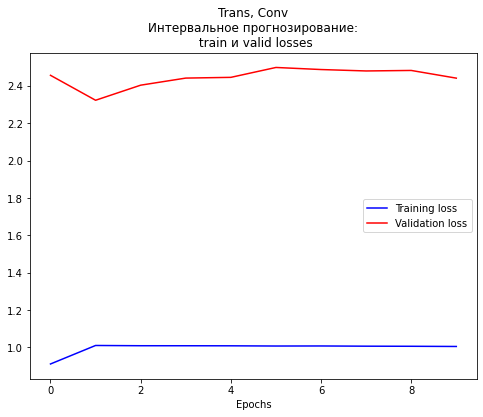

In [95]:
mpl.rcParams['figure.figsize'] = (8, 6)

loss_history_plot(loss_history,
                   'Trans, Conv\nИнтервальное прогнозирование:\n train и valid losses')

#### 2) trans, not conv 

In [96]:
%%time

dataloaders = {
    "train": train_multi_dataloader, 
    "val": val_multi_dataloader
}

model = SP100LstmTransNet(
    predict_num=predict_num, input_size=INPUT_SIZE, criterion=nn.MSELoss(),  
    dropout=0.3, hidden_size=100, 
    lstm_or_trans="trans", num_enc_dec_layers=6, 
    has_conv=False, second_cell=True,  # added second_cell
).to(device)
optimizer = torch.optim.Adadelta(model.parameters())

model, loss_history = train_model(
    model=model, dataloaders=dataloaders, 
    optimizer=optimizer, num_epochs=10)

multi_models["Trans NotConv"] = model

Epoch 1/10
train Loss: 0.6490
val Loss: 1.8241

Epoch 2/10
train Loss: 0.6034
val Loss: 1.3948

Epoch 3/10
train Loss: 0.8481
val Loss: 3.1860

Epoch 4/10
train Loss: 1.0018
val Loss: 2.4876

Epoch 5/10
train Loss: 0.9993
val Loss: 2.5919

Epoch 6/10
train Loss: 0.9973
val Loss: 2.7128

Epoch 7/10
train Loss: 0.9976
val Loss: 2.6054

Epoch 8/10
train Loss: 0.9953
val Loss: 2.6012

Epoch 9/10
train Loss: 0.9948
val Loss: 2.5887

Epoch 10/10
train Loss: 0.9942
val Loss: 2.7396

Training complete in 18m 11s
CPU times: user 13min 25s, sys: 4min 42s, total: 18min 8s
Wall time: 18min 11s


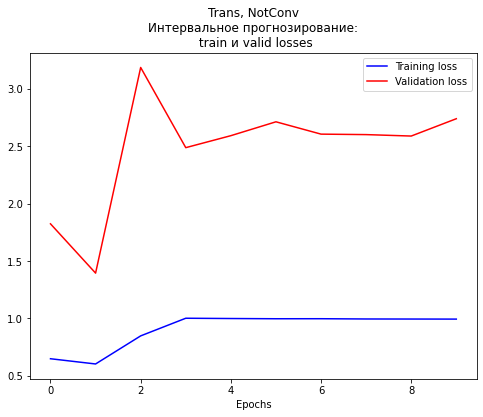

In [97]:
mpl.rcParams['figure.figsize'] = (8, 6)

loss_history_plot(loss_history,
                   'Trans, NotConv\nИнтервальное прогнозирование:\n train и valid losses')

### Тест-прогнозы

In [ ]:
# for x, y in list(val_multi_dataloader)[:10]:
#     print(x[:1].to(device).shape)

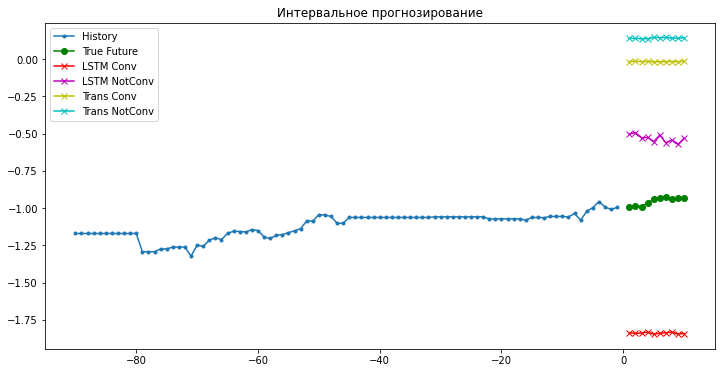

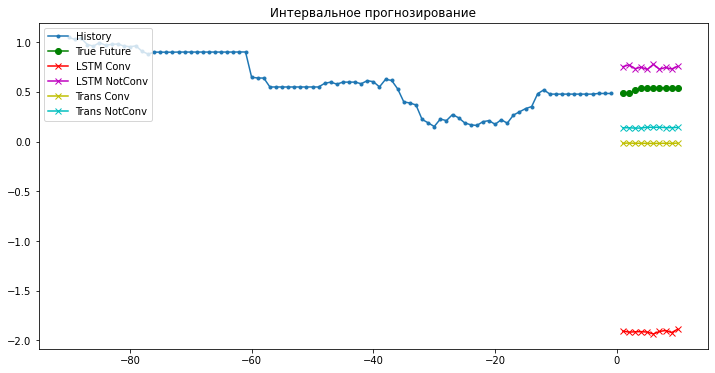

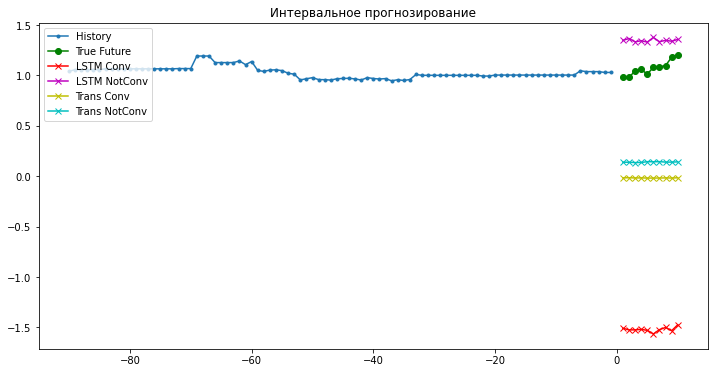

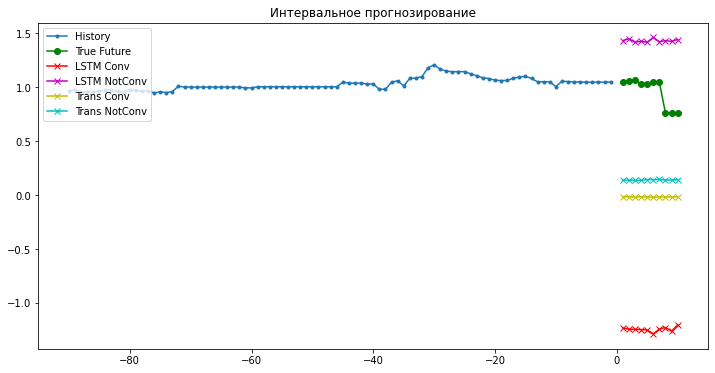

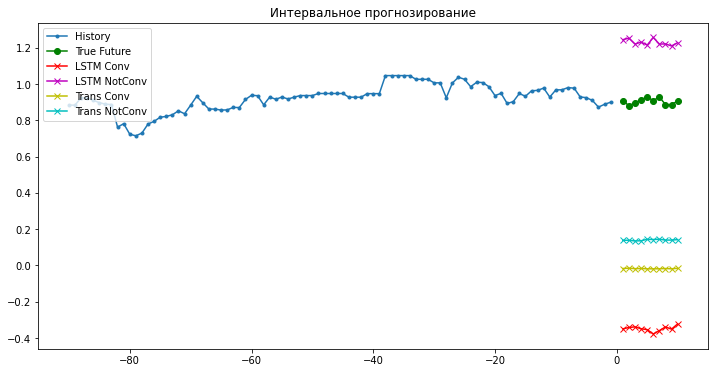

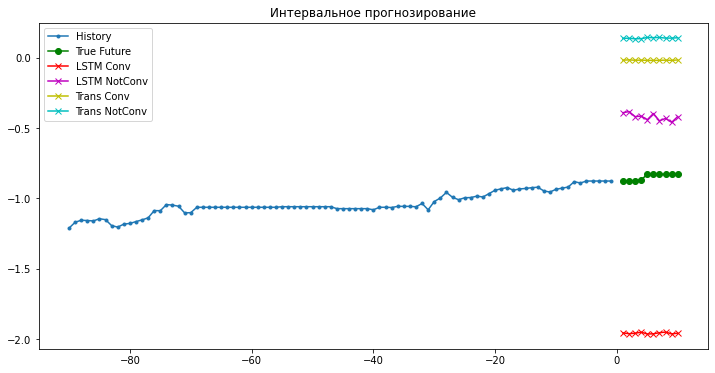

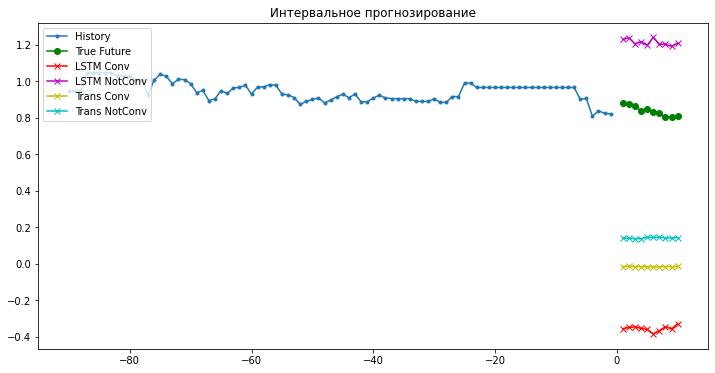

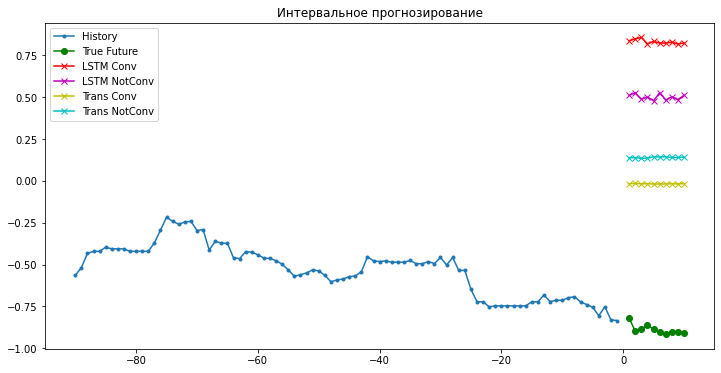

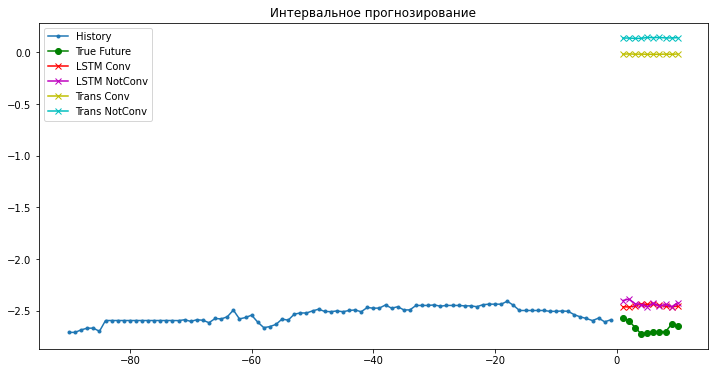

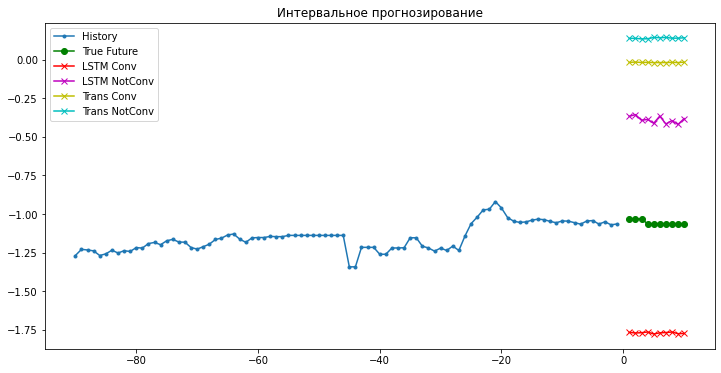

In [98]:
for x, y in list(val_multi_dataloader)[:10]:
  history_predict_plot(x[0], y[0], 
                       {key: model(x[:1].to(device)).detach().cpu().numpy() 
                                        for key, model in multi_models.items()},  
                       "Интервальное прогнозирование", 
                       future_target=future_target_multi, predict_num=predict_num)